In [12]:
%matplotlib inline

import requests
import json
import ollama
from yahoofinancials import YahooFinancials  
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import date

#basic imports


In [13]:
target_company = ["AAPL"] #request will do fine if this is multiple, but yahoofinancials dies

x = requests.get(f'https://api.marketaux.com/v1/news/all?symbols={"%2C".join(target_company)}&filter_entities=true&language=en&api_token=nYwajmcd8FBi5qGAea9eJe2mHyaI78XFdNEIie8C')
# fetch 3 stock articles from marketaux.com

In [42]:

obj = json.loads(x.text) #take web request and put text into JSON object to look readable
json_formatted_str = json.dumps(obj, indent=4)
print(json_formatted_str) # print readable JSON object
text_lines = json_formatted_str.split("\n")
sentiments = []
for i in text_lines:
    if "sentiment" in i:
        sentiments.append(i)
print([i for i in sentiments])

{
    "meta": {
        "found": 78752,
        "returned": 3,
        "limit": 3,
        "page": 1
    },
    "data": [
        {
            "uuid": "d7fcf1ff-16e5-4ea9-91ed-ef0765a456f3",
            "title": "The Evolution and Impact of Apple Inc. in the Tech World",
            "description": "Apple Inc. stands as one of the most influential companies in the technology landscape, renowned for its innovative products and unique approach to design and functionality. Founded in 1976 by Steve\u2026",
            "keywords": "",
            "snippet": "The Evolution and Impact of Apple Inc. in the Tech World Jason Taylor \u00b7 Follow 2 min read \u00b7 Just now Just now -- Share\n\nApple\n\nIntroduction\n\nApple Inc. stands...",
            "url": "https://medium.com/@viperpowerski/the-evolution-and-impact-of-apple-inc-in-the-tech-world-7214841e34ea",
            "image_url": "https://miro.medium.com/v2/resize:fit:1024/1*BcI62Ihw2h9nH1te1vmmcg.jpeg",
            "language": "en",
    

In [34]:
def get_response(message): #method to get response from local LLM
  modelfile='''
  FROM mistral-nemo:latest
  SYSTEM You are a predictive stock price model. Your job is to guess the stock price for a period of time into the future, as specified by the user. Return no text whatsoever. Only numbers in JSON format
  '''

  ollama.create(model='example', modelfile=modelfile) # attempt to create a model with system prompt for more accurate response. 
  
  #response = ollama.chat(model='llama3.1', messages=[
  response = ollama.chat(model='example', messages=[
# use new model with system prompt and generate response in accordance with what has been put into the function
    {
      'role': 'user',
      'content': message,
    },
  ])
  return (response['message']['content']) # return LLM response

Today's date: 2024-09-14
('2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04

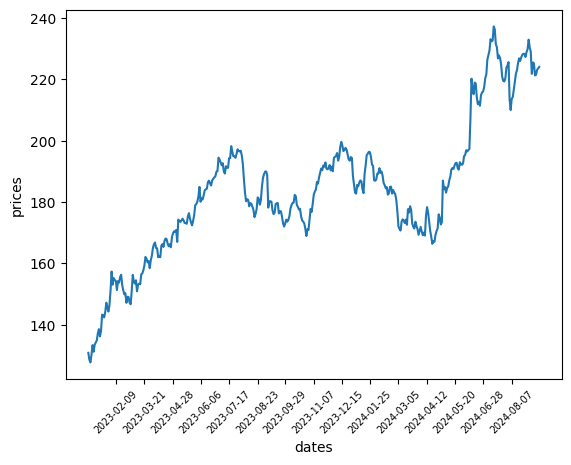

In [35]:
from datetime import date

today = date.today()
print("Today's date:", today) # get date

financials = YahooFinancials(target_company[0]) # define yahoofinancials object
price_data = financials.get_historical_price_data(start_date="2023-01-01", end_date=str(today), time_interval="daily") # fetch yahoo price data
#print(price_data["MSFT"]["prices"])
dates = []
prices = []
for count, i in enumerate(price_data[target_company[0]]["prices"]): #parse yahoo data and harvest: date and highest stock price for respective date
    dates.append(i["formatted_date"]) 
    prices.append(i["high"])

print(tuple(i for i in dates))
print(tuple(i for i in prices))


'''
The following code just takes this date and stock price and puts it into a nice graph. Nothing crucial
It defines the graph, picks dates to label (because if we picked all of them the text would overlap visually)
Then it just plots date to prices
'''


fig, ax = plt.subplots()
#axes = plt.axes()
ax.plot(dates,prices)

#dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
#plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
display_dates = []
advance_by = len(dates)/16
#print(f"size: {len(dates)}")
for i in dates:
    try:
        display_dates.append(dates[int(advance_by)])
        advance_by += len(dates)/16
        #print(f"appended {advance_by} --> {dates[int(advance_by)]}")
    except:
        pass

plt.xticks(display_dates)

plt.xticks(rotation=45, fontweight='light',  fontsize='x-small',)




plt.ylabel("prices")
plt.xlabel("dates")
plt.show()

In [36]:
dates_and_prices = []
for count, i in enumerate(prices): #what we're trying to do here is not use all of the stock and date data because it overwhelms the llm. instead, take samples at evenly spaced intervals with modulus. 
    if count % 10 == 0: #too many can flood the llm and make it spout garbage
        dates_and_prices.append([dates[count], prices[count]])

print(tuple(i for i in dates_and_prices))

(['2023-01-03', 130.89999389648438], ['2023-01-18', 138.61000061035156], ['2023-02-01', 146.61000061035156], ['2023-02-15', 155.5], ['2023-03-02', 146.7100067138672], ['2023-03-16', 156.4600067138672], ['2023-03-30', 162.47000122070312], ['2023-04-14', 166.32000732421875], ['2023-04-28', 169.85000610351562], ['2023-05-12', 174.05999755859375], ['2023-05-26', 175.77000427246094], ['2023-06-12', 183.88999938964844], ['2023-06-27', 188.38999938964844], ['2023-07-12', 191.6999969482422], ['2023-07-26', 195.63999938964844], ['2023-08-09', 180.92999267578125], ['2023-08-23', 181.5500030517578], ['2023-09-07', 178.2100067138672], ['2023-09-21', 176.3000030517578], ['2023-10-05', 175.4499969482422], ['2023-10-19', 177.83999633789062], ['2023-11-02', 177.77999877929688], ['2023-11-16', 190.9600067138672], ['2023-12-01', 191.55999755859375], ['2023-12-15', 198.39999389648438], ['2024-01-02', 188.44000244140625], ['2024-01-17', 182.92999267578125], ['2024-01-31', 187.10000610351562], ['2024-02-14

In [44]:
#prompt = (f" give me a JSON of {target_company[0]} stock price for the next month INTO THE FUTURE. start the table at today's date. the start date is currently {str(today)}. end it one month out from now. 2 day intervals. where do you predict it to go IN NUMBERS? Here's some news: {x.text} currently the stock price is {prices[-1]}")
prompt = (f" give me a JSON of {target_company[0]} stock price for the next month INTO THE FUTURE. start the table at today's date. the start date is currently {str(today)}. end it one month out from now. 2 day intervals. where do you predict it to go IN NUMBERS? sentiment analysis of the latest news is {[i for i in sentiments]} and the current price is {prices[-1]}")

print(get_response(prompt)) # get final response through LLM. currently still WIP because llama sucks at this. 
#print(prompt)
#nd here's stock prices and dates: {tuple(i for i in dates_and_prices)}

{"dates": ["2024-09-14", "2024-09-16", "2024-09-18", "2024-09-20", "2024-09-22", "2024-09-24", "2024-09-26", "2024-09-28", "2024-09-30"], "prices": [224.04, 225.12, 226.29, 227.45, 228.62, 229.78, 230.95, 232.11, 233.27]}
 give me a JSON of AAPL stock price for the next month INTO THE FUTURE. start the table at today's date. the start date is currently 2024-09-14. end it one month out from now. 2 day intervals. where do you predict it to go IN NUMBERS? sentiment analysis of the latest news is ['                    "sentiment_score": 0.58555,', '                            "sentiment": 0.8055,', '                            "sentiment": 0.765,', '                            "sentiment": 0.7717,', '                            "sentiment": 0,', '                    "sentiment_score": 0.573673,', '                            "sentiment": 0,', '                            "sentiment": 0.9423,', '                            "sentiment": 0.128,', '                            "sentiment": 0.87